In [ ]:
import tensorflow as tf
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

97
0.0
1.0
(256, 416, 3)


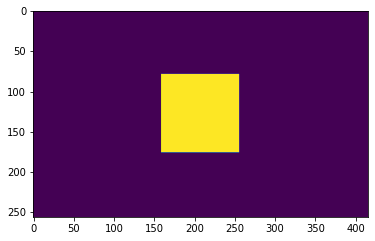

In [ ]:
beta = 0.09
size = 2500
r = int(np.sqrt(256 * 416 * beta))
print(r)
Mb = np.ones((r, r), float)
# Mb = np.ones((100, 100), float)
rb = int((256 - r)/2)
rh = int((416 - r)/2)
mask = cv2.copyMakeBorder(Mb, rb, rb+1, rh, rh+1, cv2.BORDER_CONSTANT)
plt.imshow(mask)
print(mask[0][0])
print(mask[rb][rh+1])
mask_img = np.array([mask]*3)
mask_img = np.reshape(mask_img, [256, 416, 3]).astype(float)
print(mask_img.shape)

In [ ]:
max_img = 2500
tar_lab_list = []
tar_img_list = []
tar_id_list = []
import os
i = 0
for r, d, f in os.walk('/content/drive/MyDrive/gtFine/train/'):
    for fname in f:
        if fname.endswith('gtFine_labelIds.png') and i < max_img:
            # if fname[:-17] in tar_img_list[i]:
            tar_id_list.append(os.path.join(r, fname))
            tar_lab_list.append(tar_id_list[-1][:-12]+'color.png')
            tar_img_list.append(os.path.join('/content/drive/MyDrive/leftImg8bit/train/'+r[36:],
                                             fname[:-20])+'_leftImg8bit.png')
            i += 1

In [ ]:
from shutil import copyfile
for i in range(max_img):
    fname = '/content/drive/MyDrive/02_images/'+src_img_list[i]
    copyfile(fname, '/content/drive/MyDrive/cs512_proj_data/source_img/'+src_img_list[i])
    fname = '/content/drive/MyDrive/02_labels/'+src_lab_list[i]
    copyfile(fname, '/content/drive/MyDrive/cs512_proj_data/source_lab/'+src_lab_list[i])
    copyfile(tar_img_list[i], '/content/drive/MyDrive/cs512_proj_data/target_img/'+tar_img_list[i].split('/')[-1])
    copyfile(tar_lab_list[i], '/content/drive/MyDrive/cs512_proj_data/target_lab/'+tar_lab_list[i].split('/')[-1])
    copyfile(tar_id_list[i], '/content/drive/MyDrive/cs512_proj_data/target_id/'+tar_id_list[i].split('/')[-1])

In [ ]:
def trans_imag(base, tar_paths, src_paths, tar_lab_paths, width, height, size, mask):
    trans_imgs = []
    for i in range(size):
        tar_img = cv2.imread(base+'target_img/'+tar_paths[i], 1)
        src_img = cv2.imread(base+'source_img/'+src_paths[i], 1)
        tar_lab = cv2.imread(base+'target_lab/'+tar_lab_paths[i])
        tar_img = cv2.resize(tar_img, (width, height))
        src_img = cv2.resize(src_img, (width, height))

        tar_img_fft = tf.signal.fft2d(tf.cast(tar_img, tf.complex64))
        src_img_fft = tf.signal.fft2d(tf.cast(src_img, tf.complex64))
        tar_lab_fft = tf.signal.fft2d(tf.cast(tar_lab, tf.complex64))
        # print('fft')
        out = tf.complex(tf.math.multiply(mask, tf.math.real(src_img_fft)) + 
                        tf.math.multiply((1 - mask), tf.math.real(tar_img_fft)), tf.math.imag(tar_img_fft))
        out = tf.signal.ifft2d(out)
        out = tf.math.real(out).numpy()
        out = cv2.normalize(out, out, 0, 255, cv2.NORM_MINMAX)
        out = out / 127.5 - 1
        trans_imgs.append(out)
    return np.array(trans_imgs)

In [ ]:
def imag_prepare(base, paths, width, height, size):
    imgs = []
    for i in range(size):
        img = cv2.imread(base+paths[i])
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
        imgs.append(img)
    return np.array(imgs)

In [ ]:
def lab_prepare(base, paths, width, height, classes, size):
    labs = []
    for i in range(size):
        img_lab = np.zeros((height, width, classes))
        img = cv2.imread(base+paths[i])
        img = cv2.resize(img, (width, height))
        chs_len = 0
        k_chs = 0
        for k in range(3):
            chs = np.unique(img[:,:,k])
            if len(chs) > chs_len:
                chs_len = len(chs)
                k_chs = k
        class_labs, cts = np.unique(img[:,:,k_chs], return_counts=True)
        sorted_class_labs = np.argsort(-cts)
        for j in range(classes):
            img_lab[:,:,j] = (img[:,:,k_chs]==class_labs[sorted_class_labs][j]).astype(int)
        labs.append(img_lab)
    return np.array(labs)

In [ ]:
def id_prepare(base, paths, width, height, classes, size):
    ids = []
    picked_labs = [1,4,7,8,11,12,17,19,21,23,25,26,33]
    for i in range(size):
        img_id = np.zeros((height, width, classes))
        img = cv2.imread(base+paths[i])
        img = cv2.resize(img, (width, height))
        class_ids = np.unique(img)
        for j in range(classes):
            img_id[:,:,j] = (img[:,:,0]==picked_labs[j]).astype(int)
        ids.append(img_id)
    return np.array(ids)

In [ ]:
s_pass = os.listdir('/content/drive/MyDrive/cs512_proj_data/source_img/')
s_lab = os.listdir('/content/drive/MyDrive/cs512_proj_data/source_lab/')
t_pass = os.listdir('/content/drive/MyDrive/cs512_proj_data/target_img/')
t_lab = os.listdir('/content/drive/MyDrive/cs512_proj_data/target_lab')
t_id = os.listdir('/content/drive/MyDrive/cs512_proj_data/target_id')

In [ ]:
s_imgs = imag_prepare('/content/drive/MyDrive/cs512_proj_data/source_img/', s_pass, 416, 256, size)
t_imgs = imag_prepare('/content/drive/MyDrive/cs512_proj_data/target_img/', t_pass, 416, 256, size)
s_labs = lab_prepare('/content/drive/MyDrive/cs512_proj_data/source_lab/', s_lab, 416, 256, 13, size)
t_labs = lab_prepare('/content/drive/MyDrive/cs512_proj_data/target_lab/', t_lab, 416, 256, 13, size)
t_ids = id_prepare('/content/drive/MyDrive/cs512_proj_data/target_id/', t_id, 416, 256, 13, size)
trans_imgs = trans_imag('/content/drive/MyDrive/cs512_proj_data/', t_pass, s_pass, t_lab, 416, 256, size, mask_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


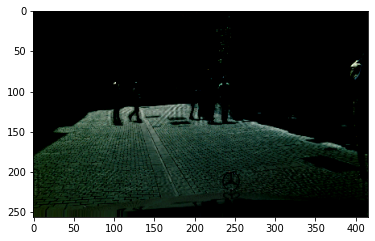

In [ ]:
plt.imshow(trans_imgs[2])

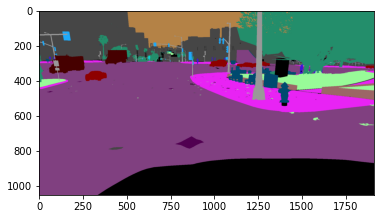

In [ ]:
plt.imshow(cv2.imread('/content/drive/MyDrive/cs512_proj_data/source_lab/02901.png'))

In [ ]:
sss = cv2.imread('/content/drive/MyDrive/cs512_proj_data/source_lab/02901.png')

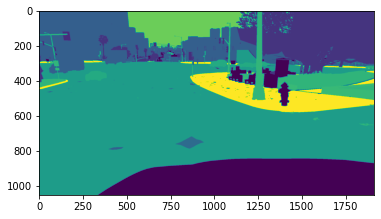

In [ ]:
plt.imshow(sss[:,:,0])

In [ ]:
train_size = int(size * 0.7)
val_size = int(size * 0.2)

X_train = t_imgs[:train_size]
Y_train = t_ids[:train_size]
X_val = t_imgs[train_size:train_size+val_size]
Y_val = t_ids[train_size:train_size+val_size]
X_test = s_imgs[train_size+val_size:]
Y_test = s_labs[train_size+val_size:]

In [ ]:
vgg_path = '/content/drive/MyDrive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
# External source please refer to: https://fairyonice.github.io/Learn-about-Fully-Convolutional-Networks-for-semantic-segmentation.html
def FCN8(nClasses ,  height, width):
    input = tf.keras.Input(shape=(height,width,3))
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1', data_format="channels_last" )(input)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2', data_format="channels_last" )(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool1', data_format="channels_last" )(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3', data_format="channels_last" )(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='conv4', data_format="channels_last" )(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool2', data_format="channels_last" )(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv5', data_format="channels_last" )(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv6', data_format="channels_last" )(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='conv7', data_format="channels_last" )(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool3', data_format="channels_last" )(x)
    pool3 = x
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv8', data_format="channels_last" )(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv9', data_format="channels_last" )(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv10', data_format="channels_last" )(x)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool4', data_format="channels_last" )(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv11', data_format="channels_last" )(pool4)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv12', data_format="channels_last" )(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same', name='conv13', data_format="channels_last" )(x)
    pool5 = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='pool5', data_format="channels_last" )(x)
    vgg  = tf.keras.Model(input, pool5)
    vgg.load_weights(vgg_path)
    
    o = (tf.keras.layers.Conv2D(4096, (7, 7) , activation='relu', padding='same', name="conv14", data_format="channels_last"))(pool5)
    conv7 = (tf.keras.layers.Conv2D(4096, (1, 1) , activation='relu', padding='same', name="conv15", data_format="channels_last"))(o)

    conv7_4 = tf.keras.layers.Conv2DTranspose(nClasses, kernel_size=(4, 4), strides=(4, 4), use_bias=False, data_format="channels_last")(conv7)
    pool411 = (tf.keras.layers.Conv2D(nClasses, (1, 1), activation='relu', padding='same', name="pool4_11", data_format="channels_last"))(pool4)
    pool411_2 = (tf.keras.layers.Conv2DTranspose(nClasses, kernel_size=(2, 2),  strides=(2,2), use_bias=False, data_format="channels_last"))(pool411)  
    pool311 = (tf.keras.layers.Conv2D(nClasses, (1, 1), activation='relu', padding='same', name="pool3_11", data_format="channels_last"))(pool3)   
    o = tf.keras.layers.Add(name="add")([pool411_2, pool311, conv7_4])
    o = tf.keras.layers.Conv2DTranspose(nClasses, kernel_size=(8, 8),  strides=(8, 8), use_bias=False, data_format="channels_last")(o)
    o = (tf.keras.layers.Activation('softmax'))(o)   
    model = tf.keras.Model(input, o)
    return model

In [ ]:
model = FCN8(13, 256, 416)
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam')
hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=20)
Dt_losses = np.array(hist.history['loss']).astype(float)
Dt_iter = iter(Dt_losses)

Model: "functional_39"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 416, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 416, 64) 1792        input_10[0][0]                   
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 256, 416, 64) 36928       conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 128, 208, 64) 0           conv2[0][0]                      
______________________________________________________________________________________

In [ ]:
model.save('/content/drive/MyDrive/model1.h5')

In [ ]:
Y_pred = model.predict(X_test)
Y_pred = np.rint(Y_pred)
iou = []
uniq_pred = np.argmax(Y_pred, axis=3)
uniq_true = np.argmax(Y_test, axis=3)

for i in range(13):
    TP = np.sum((i == uniq_true) & (i == uniq_pred))
    FP = np.sum((i != uniq_true) & (i == uniq_pred))
    FN = np.sum((i == uniq_true) & (i != uniq_pred))
    iou.append(TP/(TP + FP + FN).astype(float))
miou = np.array(iou).mean() * 100
print('mIoU = ' + str(miou))

mIoU = 2.8673160804868036


In [ ]:
X_train = trans_imgs[:train_size]
Y_train = t_ids[:train_size]
X_val = trans_imgs[train_size:train_size+val_size]
Y_val = t_ids[train_size:train_size+val_size]
X_test = s_imgs[train_size+val_size:]
Y_test = s_labs[train_size+val_size:]

In [ ]:
i = 0
def My_loss(y_pred, y_true):
    global i
    mul_log = tf.math.log(y_pred + 0.0001)
    mul = tf.multiply(y_true, mul_log)
    loss_ce = -tf.reduce_sum(mul)
    tot_loss = loss_ce + 0.005 * (Dt_losses[i].astype(float) ** 2 + 0.00001) ** 2
    i += 1
    return tot_loss

In [ ]:
model_trans = FCN8(13, 256, 416)
model_trans.summary()
model_trans.compile(loss='categorical_crossentropy', optimizer='adam')
hist = model_trans.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=32, epochs=20)

In [ ]:
model_trans.save('/content/drive/MyDrive/model2.h5')

In [ ]:
Y_pred_trans = model_trans.predict(X_test)
Y_pred_trans = np.rint(Y_pred_trans)
iou = []
uniq_pred = np.argmax(Y_pred_trans, axis=3)
uniq_true = np.argmax(Y_test, axis=3)

for i in range(13):
    TP = np.sum((i == uniq_true) & (i == uniq_pred))
    FP = np.sum((i != uniq_true) & (i == uniq_pred))
    FN = np.sum((i == uniq_true) & (i != uniq_pred))
    iou.append(TP/(TP + FP + FN).astype(float))
miou = np.array(iou).mean() * 100
print('mIoU = ' + str(miou))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


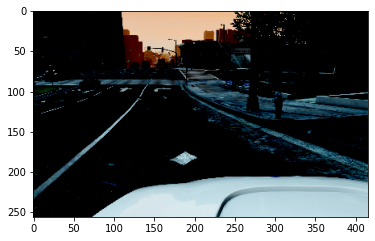

In [ ]:
plt.imshow(s_imgs[0])

(256, 416)
(256, 416)


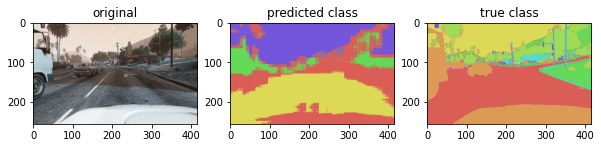

(256, 416)
(256, 416)


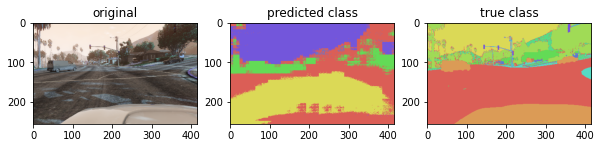

(256, 416)
(256, 416)


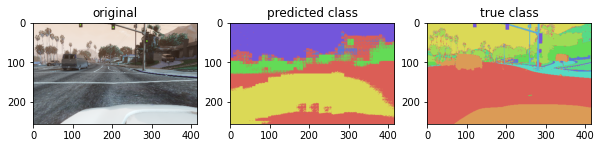

(256, 416)
(256, 416)


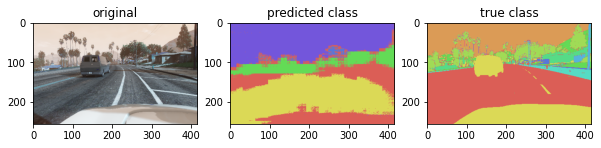

(256, 416)
(256, 416)


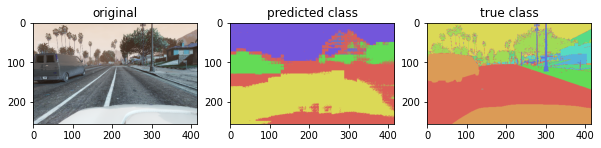

In [ ]:
# External source please refer to: https://fairyonice.github.io/Learn-about-Fully-Convolutional-Networks-for-semantic-segmentation.html
def give_color_to_seg_img(seg,n_classes):
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)

    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

shape = (256, 416)
n_classes= 13


for i in range(5):
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = uniq_pred[i]
    print(seg.shape)
    segtest = uniq_true[i]
    print(segtest.shape)

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")
    plt.show()